In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import copy
import time
from datetime import datetime, timedelta

import PIL
import numpy as np
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from torch import nn
from torch.autograd import Variable
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import utils
from data_manager.dataset import dataset_Aptos, dataset_eyepacs
from loss.MultiClassMetrics import *
# from models.FinetuneVTmodels import MIL_VT_FineTune
from utils import *
torch.multiprocessing.set_sharing_strategy('file_system')
from util_folder.vision_transformers import VitGenerator
from util_folder.preprocess import Loader, visualize_predict, get_predict_vis
from PIL import Image
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if device.type == "cuda":
    torch.cuda.set_device(0)
from models.FinetuneVTmodels_MOD import MIL_VT_FineTune

In [48]:
a = torch.Tensor([[1,2,3],[1,2,3]])
b = torch.Tensor([[2,3,4],[2,3,4]])
c = torch.mul(a,b).sum(dim=1, keepdim=True)
c

tensor([[20.],
        [20.]])

In [3]:
n_classes = 5
img_size = 512
base_model = 'MIL_VT_small_patch16_'+str(img_size)  #nominate the MIL-VT model to be used
MODEL_PATH_finetune = 'weights/fundus_pretrained_VT_small_patch16_384_5Class.pth.tar'
dateTag = datetime.today().strftime('%Y%m%d')
prefix = base_model + '_' + dateTag

model = MIL_VT_FineTune(base_model, MODEL_PATH_finetune, num_classes=n_classes)



Missing Key not in pretrain model:  MIL_Prep.0.weight
Missing Key not in pretrain model:  MIL_Prep.0.bias
Missing Key not in pretrain model:  MIL_Prep.1.weight
Missing Key not in pretrain model:  MIL_Prep.1.bias
Missing Key not in pretrain model:  MIL_attention.0.weight
Missing Key not in pretrain model:  MIL_attention.0.bias
Missing Key not in pretrain model:  MIL_attention.1.weight
Missing Key not in pretrain model:  MIL_attention.1.bias
Missing Key not in pretrain model:  MIL_attention.4.weight
Missing Key not in pretrain model:  MIL_attention.4.bias
Missing Key not in pretrain model:  MIL_classifier.0.weight
Missing Key not in pretrain model:  MIL_classifier.0.bias
Removing key head.weight from pretrained checkpoint
Removing key head.bias from pretrained checkpoint
Removing key head_dist.weight from pretrained checkpoint
Removing key head_dist.bias from pretrained checkpoint
pos_embed:  384 1024 1


In [6]:
for name, layer in model.named_modules():
    print("Name: ", name)
    print("Layer: ", layer)

Name:  
Layer:  MILVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0, inplace=False)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerN

In [19]:
# Copyright (c) Facebook, Inc. and its affiliates & Vittorio Mazzia.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Mostly copy-paste from timm library.
https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
"""
import math
from functools import partial
import torch
import torch.nn as nn



def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def prepare_tokens(self, x):
        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h)

        return self.pos_drop(x)

    def forward(self, x):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x[:, 0]

    def get_last_selfattention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)

    def get_intermediate_layers(self, x, n=1):
        x = self.prepare_tokens(x)
        # we return the output tokens from the `n` last blocks
        output = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if len(self.blocks) - i <= n:
                output.append(self.norm(x))
        return output


class  VitGenerator(object):
    def __init__(self, name_model, patch_size, device, evaluate=True, random=False, verbose=False):
        self.name_model = name_model
        self.patch_size = patch_size
        self.evaluate = evaluate
        self.device = device
        self.verbose = verbose
        self.model = self._getModel()
        self._initializeModel()
        if not random:
            self._loadPretrainedWeights()

    def _getModel(self):
        if self.verbose:
            print(f"[INFO] Initializing {self.name_model} with patch size of {self.patch_size}")
        if self.name_model == 'vit_tiny':
                model = VisionTransformer(patch_size=self.patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4,
                        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        elif self.name_model == 'vit_small':
                model = VisionTransformer(patch_size=self.patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4,
                        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        elif self.name_model == 'vit_base':
                model = VisionTransformer(patch_size=self.patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
                        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))
        else:
            raise f"No model found with {self.name_model}"


        return model

    def _initializeModel(self):
        if self.evaluate:
            for p in self.model.parameters():
                p.requires_grad = False

            self.model.eval()

        self.model.to(self.device)

    def _loadPretrainedWeights(self):
        if self.verbose:
            print("[INFO] Loading weights")
        url = None
        if self.name_model == 'vit_small' and self.patch_size==16:
            url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"

        elif self.name_model == 'vit_small' and self.patch_size == 8:
            url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"

        elif self.name_model == 'vit_base' and self.patch_size == 16:
            url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"

        elif self.name_model == 'vit_base' and self.patch_size == 8:
            url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"


        if url is None:
            print(f"Since no pretrained weights have been found with name {self.name_model} and patch size {self.patch_size}, random weights will be used")

        else:
            state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
            self.model.load_state_dict(state_dict, strict=True)

    def get_last_selfattention(self, img):
        return self.model.get_last_selfattention(img.to(self.device))

    def __call__(self, x):
        return self.model(x)



In [20]:
print(model)

MILVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv

In [28]:
# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.
import torch
import torch.nn as nn
from functools import partial
from collections import OrderedDict

# from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_
from timm.models import create_model




def rename_pretrain_weight(checkpoint):
    state_dict_old = checkpoint['state_dict']
    state_dict_new = OrderedDict()
    for key, value in state_dict_old.items():
        state_dict_new[key[len('module.'):]] = value
    return state_dict_new



#LoadTongrenPretrainedWeight_NoDistillation
def MIL_VT_FineTune(base_model='MIL_VT_small_patch16_384',  \
                      MODEL_PATH_finetune = 'weights/fundus_pretrained_VT_small_patch16_384_5Class.pth.tar', \
                      num_classes=5):
    """Load pretrain weight from distillation model, to train a plain model"""

    model = create_model(model_name=base_model,
            pretrained=False,
            num_classes=num_classes,
            drop_rate=0,
            drop_path_rate=0.1,
            drop_block_rate=None,
        )
    evaluate = True
    if evaluate:
        for p in model.parameters():
            p.requires_grad = False

        model.eval()


    checkpoint0 = torch.load(MODEL_PATH_finetune, map_location='cpu')
    checkpoint_model = rename_pretrain_weight(checkpoint0)

    state_dict = model.state_dict()
    checkpoint_keys = list(checkpoint_model.keys())
    for tempKey in list(state_dict.keys()):
        if tempKey not in checkpoint_keys:
            print('Missing Key not in pretrain model: ', tempKey)


    for k in ['head.weight', 'head.bias', 'head_dist.weight', 'head_dist.bias']:
        if k in checkpoint_model: # and checkpoint_model[k].shape != state_dict[k].shape:
            print(f"Removing key {k} from pretrained checkpoint")
            del checkpoint_model[k]

    # interpolate position embedding
    pos_embed_checkpoint = checkpoint_model['pos_embed']
    embedding_size = pos_embed_checkpoint.shape[-1]
    num_patches = model.patch_embed.num_patches
    num_extra_tokens = model.pos_embed.shape[-2] - num_patches
    num_extra_tokens_chechpoint = 2
    print('pos_embed: ', embedding_size, num_patches, num_extra_tokens)

 
    # height (== width) for the checkpoint position embedding
    orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens_chechpoint) ** 0.5)
    # height (== width) for the new position embedding
    new_size = int(num_patches ** 0.5)
    # class_token and dist_token are kept unchanged
    extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
    # only the position tokens are interpolated
    pos_tokens = pos_embed_checkpoint[:, num_extra_tokens_chechpoint:]
    pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
    pos_tokens = torch.nn.functional.interpolate(
        pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
    pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
    new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
    checkpoint_model['pos_embed'] = new_pos_embed

    model.load_state_dict(checkpoint_model, strict=False)

    return model


##
import torch
import torch.nn as nn
from functools import partial
import numpy as np
# from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.models.vision_transformer import _cfg
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_


class MILVisionTransformer(VisionTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dist_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, self.embed_dim))
        # self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if self.num_classes > 0 else nn.Identity()
        self.num_classes = 5
        self.size2 = int(np.sqrt(num_patches))
        self.dim = self.embed_dim
        self.L = 256 #self.dim//3
        self.D = 128 #self.dim//5
        self.K = 1 #self.num_classes*1
        self.MIL_Prep = torch.nn.Sequential(
                torch.nn.Linear(self.dim, self.L),
                # torch.nn.BatchNorm1d(num_patches),
                torch.nn.LayerNorm(self.L),
                torch.nn.ReLU(inplace=True),
                # nn.Dropout(0.1)
                )
        self.MIL_attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            # nn.Tanh(),
            # nn.BatchNorm1d(num_patches),
            torch.nn.LayerNorm(self.D),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(self.D, self.K)

            # nn.Linear(self.L, self.K)
        )

        self.MIL_classifier = nn.Sequential(
            nn.Linear(self.L*self.K, self.num_classes),
        )


        trunc_normal_(self.pos_embed, std=.02)
        # self.head_dist.apply(self._init_weights)
        self.MIL_Prep[0].apply(self._init_weights)
        self.MIL_Prep[1].apply(self._init_weights)
        self.MIL_attention[0].apply(self._init_weights)
        self.MIL_attention[1].apply(self._init_weights)
        self.MIL_attention[4].apply(self._init_weights)
        self.MIL_classifier[0].apply(self._init_weights)

    def forward_features(self, x):
        # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
        # with slight modifications to add the dist_token

        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0], x[:, 1:]

    def forward(self, x):
        x, x_patches = self.forward_features(x)
        vt_out = self.head(x)

        """MIL operations for the """
        H = self.MIL_Prep(x_patches)  #B*N*D -->  B*N*L

        A = self.MIL_attention(H)  # B*N*K
        # A = torch.transpose(A, 1, 0)  # KxN
        A = A.permute((0, 2, 1))  #B*K*N
        A = nn.functional.softmax(A, dim=2)  # softmax over N
        M = torch.bmm(A, H)  # B*K*N X B*N*L --> B*K*L
        M = M.view(-1, M.size(1)*M.size(2))

        mil_out = self.MIL_classifier(M)

        # return vt_out, mil_out, x_patches
        if self.training:
            return vt_out, mil_out
        else:
            # during inference, return the average of both classifier predictions
            return (vt_out+ mil_out) / 2
        
    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)
        
    def prepare_tokens(self, x):
        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h)

        return self.pos_drop(x)
        
    def get_last_selfattention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)

    def get_intermediate_layers(self, x, n=1):
        x = self.prepare_tokens(x)
        # we return the output tokens from the `n` last blocks
        output = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if len(self.blocks) - i <= n:
                output.append(self.norm(x))
        return output


###################
class MILVisionTransformer_Distil(VisionTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dist_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 2, self.embed_dim))
        self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if self.num_classes > 0 else nn.Identity()

        self.size2 = int(np.sqrt(num_patches))
        self.dim = self.embed_dim
        self.L = 256 #self.dim//3
        self.D = 128 #self.dim//5
        self.K = 1 #self.num_classes*1
        self.MIL_Prep = torch.nn.Sequential(
                torch.nn.Linear(self.dim, self.L),
                # torch.nn.BatchNorm1d(num_patches),
                torch.nn.LayerNorm(self.L),
                torch.nn.ReLU(inplace=True),
                # nn.Dropout(0.1)
                )
        self.MIL_attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            # nn.Tanh(),
            # nn.BatchNorm1d(num_patches),
            torch.nn.LayerNorm(self.D),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(self.D, self.K)

            # nn.Linear(self.L, self.K)
        )

        self.MIL_classifier = nn.Sequential(
            nn.Linear(self.L*self.K, self.num_classes),
            # nn.Sigmoid()
        )

        trunc_normal_(self.dist_token, std=.02)
        trunc_normal_(self.pos_embed, std=.02)
        self.head_dist.apply(self._init_weights)
        self.MIL_Prep[0].apply(self._init_weights)
        self.MIL_Prep[1].apply(self._init_weights)
        self.MIL_attention[0].apply(self._init_weights)
        self.MIL_attention[1].apply(self._init_weights)
        self.MIL_attention[4].apply(self._init_weights)
        self.MIL_classifier[0].apply(self._init_weights)


    def forward_features(self, x):
        # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
        # with slight modifications to add the dist_token

        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        dist_token = self.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0], x[:, 1], x[:, 2:]

    def forward(self, x):
        x,  x_dist,  x_patches = self.forward_features(x)
        vt_out = self.head(x)
        dist_out = self.head_dist(x_dist)

        """MIL operations for the """
        """MIL operations for the """
        H = self.MIL_Prep(x_patches)  #B*N*D -->  B*N*L

        A = self.MIL_attention(H)  # B*N*K
        # A = torch.transpose(A, 1, 0)  # KxN
        A = A.permute((0, 2, 1))  #B*K*N
        A = nn.functional.softmax(A, dim=2)  # softmax over N
        M = torch.bmm(A, H)  # B*K*N X B*N*L --> B*K*L
        M = M.view(-1, M.size(1)*M.size(2))

        mil_out = self.MIL_classifier(M)

        # return vt_out, mil_out, x_patches
        if self.training:
            return (vt_out, dist_out), mil_out
        else:
            # during inference, return the average of both classifier predictions
            return (vt_out + dist_out + mil_out) / 3
        
        
    def get_last_selfattention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)

    def get_intermediate_layers(self, x, n=1):
        x = self.prepare_tokens(x)
        # we return the output tokens from the `n` last blocks
        output = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if len(self.blocks) - i <= n:
                output.append(self.norm(x))
        return output
#######################


###############################


@register_model
def MIL_VT_small_patch16_384(pretrained=False, **kwargs):
    model = MILVisionTransformer(
        img_size=384, patch_size=16, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint["model"])
    return model


@register_model
def MIL_VT_small_patch16_512(pretrained=False, **kwargs):
    model = MILVisionTransformer(
        img_size=512, patch_size=16, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint["model"])
    return model




In [31]:
MODEL_PATH_finetune = 'weights/fundus_pretrained_VT_small_patch16_384_5Class.pth.tar'
n_classes=5
base_model = 'MIL_VT_small_patch16_512'  #nominate the MIL-VT model to be used
model = MIL_VT_FineTune(base_model, MODEL_PATH_finetune, num_classes=n_classes)

Missing Key not in pretrain model:  MIL_Prep.0.weight
Missing Key not in pretrain model:  MIL_Prep.0.bias
Missing Key not in pretrain model:  MIL_Prep.1.weight
Missing Key not in pretrain model:  MIL_Prep.1.bias
Missing Key not in pretrain model:  MIL_attention.0.weight
Missing Key not in pretrain model:  MIL_attention.0.bias
Missing Key not in pretrain model:  MIL_attention.1.weight
Missing Key not in pretrain model:  MIL_attention.1.bias
Missing Key not in pretrain model:  MIL_attention.4.weight
Missing Key not in pretrain model:  MIL_attention.4.bias
Missing Key not in pretrain model:  MIL_classifier.0.weight
Missing Key not in pretrain model:  MIL_classifier.0.bias
Removing key head.weight from pretrained checkpoint
Removing key head.bias from pretrained checkpoint
Removing key head_dist.weight from pretrained checkpoint
Removing key head_dist.bias from pretrained checkpoint
pos_embed:  384 1024 1


In [30]:
from torchvision.models import resnet50

model = vgg16(pretrained=True)

for name, layer in model.named_modules():
    print(name, layer)


 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [42]:
model.blocks[11].attn.proj_drop

Dropout(p=0, inplace=False)

In [13]:
print(model)

MILVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv

In [23]:
loader = Loader()

FileUpload(value={}, accept='image/*', description='Upload')

In [24]:
img = loader.getLastImage()


[INFO] Image Dimension (1280, 1280)


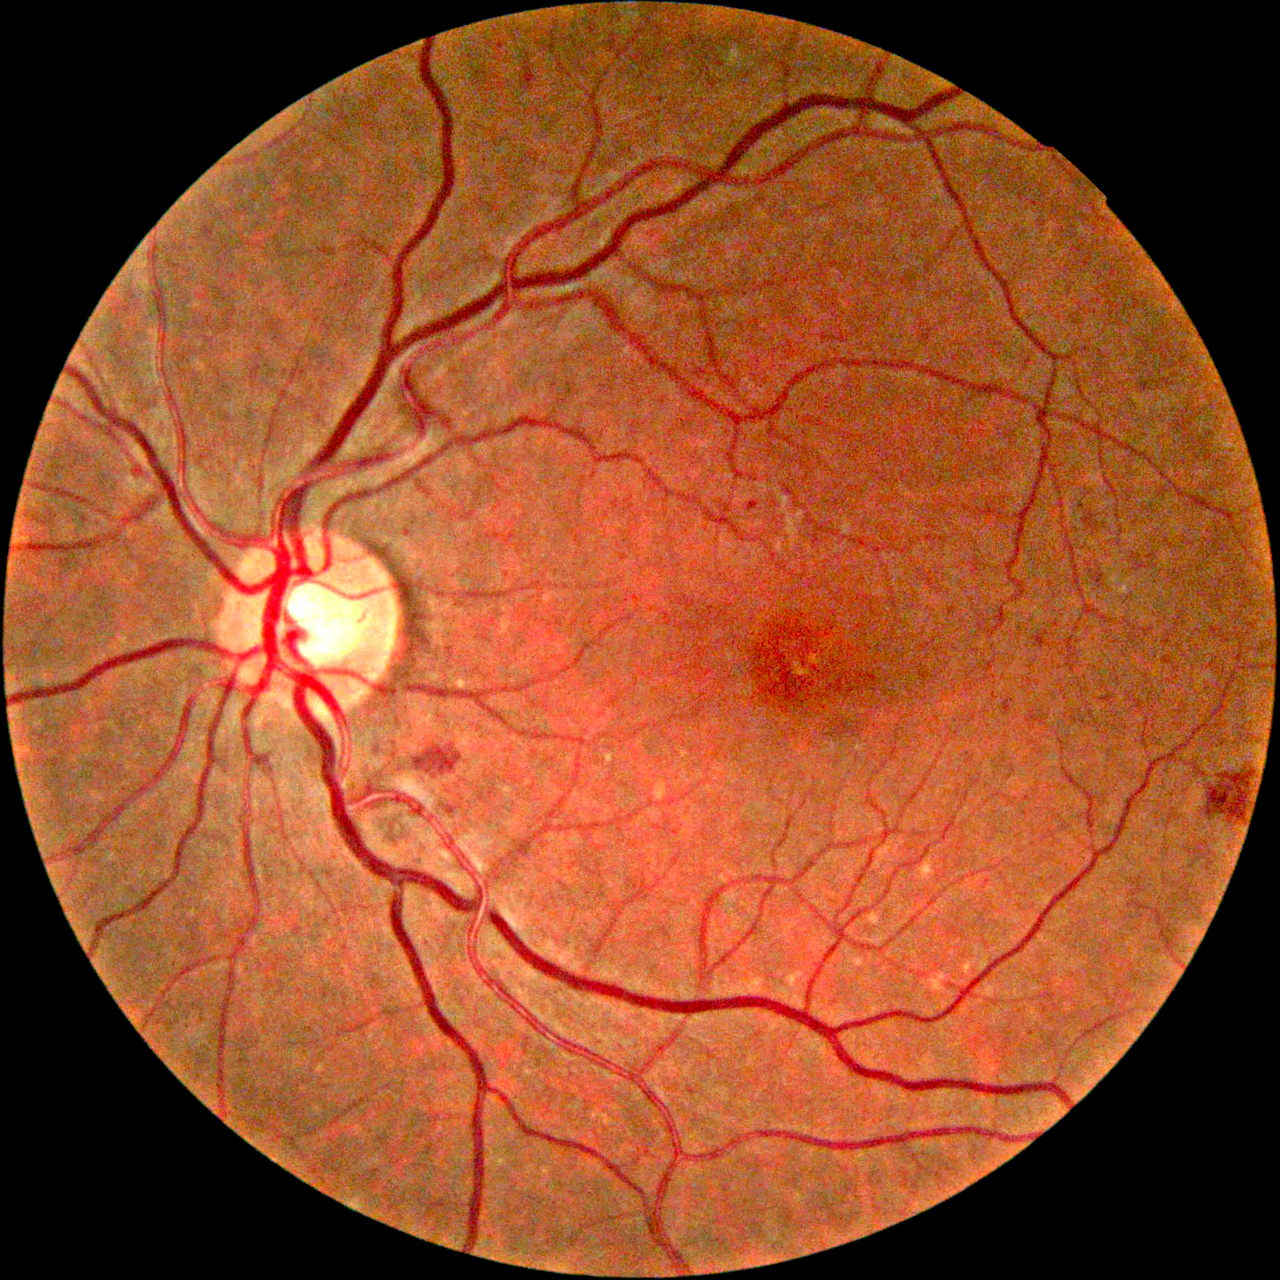

In [25]:
print(f"[INFO] Image Dimension {img.size}")
img

In [32]:
factor_reduce = 1
img_size = tuple(np.array(img.size[::-1]) // factor_reduce) # PIL works with col, row
print(img_size)
patch_size=16
print(type(img))

(1280, 1280)
<class 'PIL.PngImagePlugin.PngImageFile'>


attention shape:  torch.Size([1, 6, 1025, 1025])
(6, 512, 512) (512, 512)


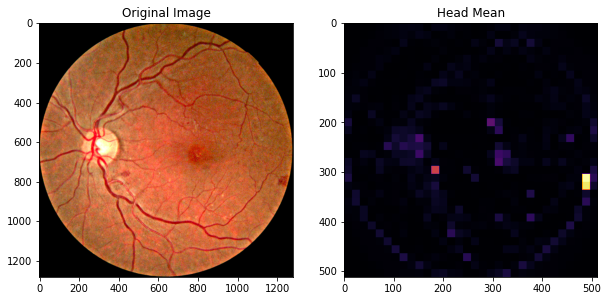

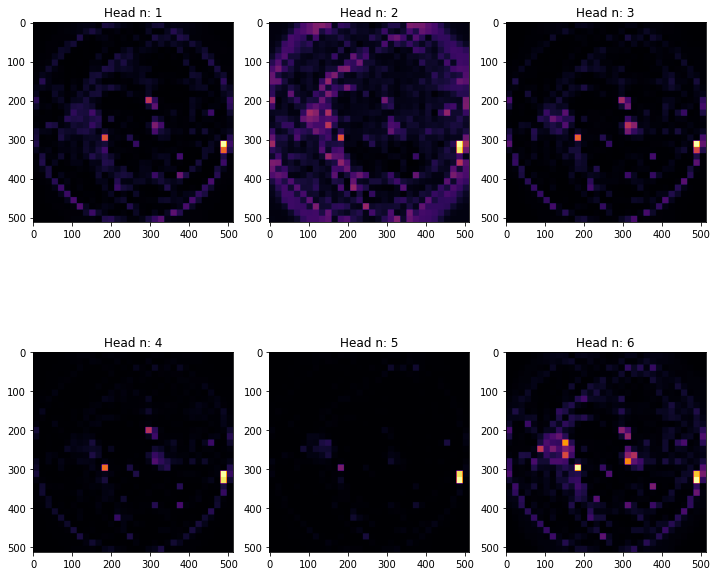

In [33]:
visualize_predict(model.to('cuda:0'), img, (512, 512), patch_size, device)

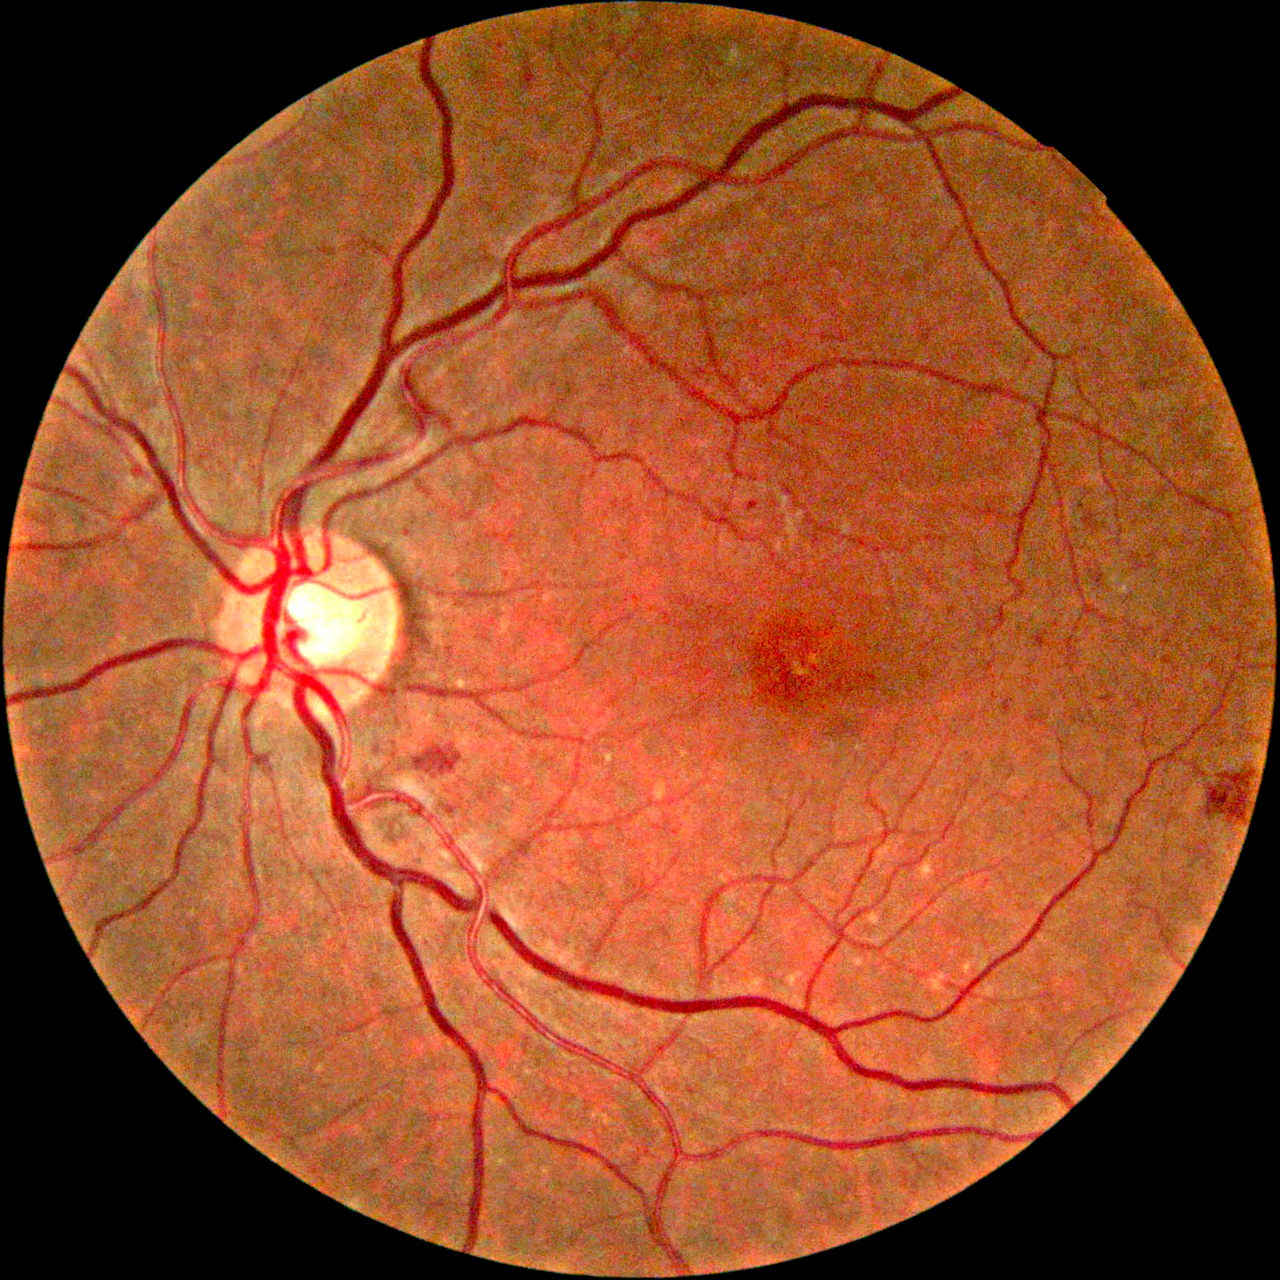

In [38]:
img

In [26]:
# w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
# print(w,h)
# img = img[:, :w, :h].unsqueeze(0)
# attn = model.get_last_selfattention(img)

get_predict_vis(model.to('cuda:0'), img, (512, 512), patch_size, device)

<class 'torch.nn.modules.activation.ReLU'>


NameError: name 'exit' is not defined